In [1]:
import numpy as np
import mxnet as mx
from mxnet import gluon
ctx = mx.gpu(0)

In [2]:
import matplotlib.pyplot as plt

# Gated PixelCNN
Causal convolution is an approximation to Recurrent Neural Network(RNN) structure.
While taking the advantage of relatively short traing time of CNN,
it is also capable of generating time-sequence such as audio waveform in permissible quality.

In this notebook, Unconditional Gated PixelCNN, which is defined in [A. van den Oord, et.al., "Conditional Image Generation with PixelCNN Decoders" _NIPS2016_](https://papers.nips.cc/paper/6527-conditional-image-generation-with-pixelcnn-decoders), is implemented with Apache MXNet, and completion of MNIST image based of upper half of the image is done.

In [3]:
class VStack(gluon.nn.Conv2D):
    '''Vertical stack of a PixelCNN layer
    
    Gluon's 2D-convolution layer modified as to capture the image context
    descending from top line to target line.
    When kernel_type is set to 'A'(default), the convolution does not rely on
    the value of same position of previous layer, which preserves *causality*.
    '''
    def __init__(self, channels, kernel_size, strides=(1, 1),
                 dilation=(1, 1), groups=1, layout='NCHW',
                 activation=None, use_bias=True, weight_initializer=None,
                 bias_initializer='zeros', in_channels=0, kernel_type='A', **kwargs):
        super(VStack, self).__init__(channels, kernel_size, strides,
                (kernel_size[0] if 'A' is kernel_type else kernel_size[0]-1, kernel_size[1]//2),
                 dilation, groups, layout,
                 activation, use_bias, weight_initializer,
                 bias_initializer, in_channels, **kwargs)

    def hybrid_forward(self, F, x, weight, bias=None):
        act = super(VStack, self).hybrid_forward(F, x, weight, bias)
        return F.slice_like(act, x, axes=[2,3])

class HStack(gluon.nn.Conv2D):
    '''Horizontal stack of a PixelCNN layer
    
    Gluon's 2D-convolution layer modified as to capture the image context
    propagating from left pixel to right pixel.
    When kernel_type is set to 'A'(default), the convolution does not rely on
    the value of same position of previous layer, which preserves *causality*.
    '''
    def __init__(self, channels, kernel_len, strides=(1, 1),
                 dilation=(1, 1), groups=1, layout='NCHW',
                 activation=None, use_bias=True, weight_initializer=None,
                 bias_initializer='zeros', in_channels=0, kernel_type='A', **kwargs):
        super(HStack, self).__init__(channels, (1,kernel_len), strides,
                (0, kernel_len if 'A' is kernel_type else kernel_len-1),
                 dilation, groups, layout,
                 activation, use_bias, weight_initializer,
                 bias_initializer, in_channels, **kwargs)

    def hybrid_forward(self, F, x, weight, bias=None):
        act = super(HStack, self).hybrid_forward(F, x, weight, bias)
        return F.slice_like(act, x, axes=[2,3])
    
class GatedLayer(gluon.HybridBlock):
    '''Implementation of a single layer in Gated PixelCNN (A. van den Oord, et.al., NIPS2016 6527)
    '''
    def __init__(self, channels, kernel_size, strides=(1, 1),
                 dilation=(1, 1), groups=1, use_bias=True, weight_initializer=None,
                 bias_initializer='zeros', in_channels=0, kernel_type='A', residual=True, **kwargs):
        super(GatedLayer, self).__init__(**kwargs)
        self.channels = channels
        self.residual = residual
        with self.name_scope():
            self.vstack = VStack(channels*2, kernel_size, strides,
                 dilation, groups, 'NCHW', None, use_bias, weight_initializer,
                 bias_initializer, in_channels, kernel_type, **kwargs)
            self.hstack = HStack(channels*2, kernel_size[1], strides,
                 dilation, groups, 'NCHW', None, use_bias, weight_initializer,
                 bias_initializer, in_channels, kernel_type, **kwargs)
            self.vtoh = gluon.nn.Conv2D(channels*2, (1,1), strides,
                 (0,0), (1,1), groups, 'NCHW', None, use_bias, weight_initializer,
                 bias_initializer, channels*2, **kwargs)
            self.htoh = gluon.nn.Conv2D(channels, (1,1), strides,
                 (0,0), (1,1), groups, 'NCHW', None, use_bias, weight_initializer,
                 bias_initializer, channels, **kwargs)
            
    def hybrid_forward(self, F, x):
        vx, hx = F.split(x, axis=1, num_outputs=2)
        vstack = self.vstack(vx)
        hstack = self.hstack(hx) + self.vtoh(vstack)
        
        vstack_presig, vstack_pretanh = F.split(vstack, axis=1, num_outputs=2)
        hstack_presig, hstack_pretanh = F.split(hstack, axis=1, num_outputs=2)
        vstack_out = F.sigmoid(vstack_presig) * F.tanh(vstack_pretanh)
        hstack_preres = self.htoh(F.sigmoid(hstack_presig) * F.tanh(hstack_pretanh))
        # residual connection for hstack
        if not self.residual:
            hstack_out = hstack_preres
        elif hx.shape[1] < self.channels:
            zpad_shape = list(hx.shape)
            zpad_shape[1] = self.channels - zpad_shape[1]
            hstack_out = hstack_preres + F.concat(hx, F.zeros(zpad_shape), dim=1)
        else:
            hstack_out = hstack_preres + hx
            
        return mx.nd.concat(vstack_out, hstack_out, dim=1)
    

## Construction of the entine network

Residual connection is omitted because it seemed degrading the quality of output images.

In [4]:
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Conv2D(8, (1,1)))
    net.add(GatedLayer(16, (5,5), kernel_type='A', residual=False))
    net.add(GatedLayer(16, (5,5), kernel_type='B', residual=False))
    net.add(GatedLayer(16, (5,5), kernel_type='B', residual=False))
    net.add(GatedLayer(16, (5,5), kernel_type='B', residual=False))
    net.add(GatedLayer(16, (5,5), kernel_type='B', residual=False))
    net.add(GatedLayer(16, (5,5), kernel_type='B', residual=False))
    net.add(gluon.nn.Conv2D(1, (1,1), activation='relu'))
net.initialize(ctx=ctx)

## Data preparation

In [5]:
train_loader = gluon.data.DataLoader(
    gluon.data.vision.MNIST('.', transform=lambda x,y: (mx.nd.transpose(x, [2,0,1]).astype(np.float32), y)), batch_size=24)
test_loader = gluon.data.DataLoader(
    gluon.data.vision.MNIST('.', train=False, transform=lambda x,y: (mx.nd.transpose(x, [2,0,1]).astype(np.float32), y)), batch_size=24)

## Training

In [6]:
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.001})

for _ in range(5):
    cumulative_loss = 0
    for x,_ in train_loader:
        x = mx.nd.array(x, ctx=ctx)
        with mx.autograd.record():
            loss = mx.nd.sum((net(x) - x)**2, axis=[1,2,3])
        loss.backward()
        trainer.step(12)
        cumulative_loss += mx.nd.mean(loss).asscalar()
    test_loss = 0
    for x, _ in test_loader:
        x = mx.nd.array(x, ctx=ctx)
        test_loss += mx.nd.mean(mx.nd.sum((net(x) - x)**2, axis=[1,2,3])).asscalar()
    print('train loss: ', cumulative_loss/len(train_loader), 'test loss: ', test_loss/len(test_loader))

train loss:  1004493.07526875 test loss:  277842.7196867506
train loss:  251292.1415125 test loss:  256197.82606414868
train loss:  239869.5419 test loss:  251650.16291966426
train loss:  232906.33226875 test loss:  245276.59303806955
train loss:  228352.43911875 test loss:  241586.5666966427


## Image completion

In [7]:
for n, (x, _) in enumerate(test_loader):
    x = mx.nd.array(x, ctx=ctx)
    reconst =mx.nd.array(x, ctx=ctx)
    if n==1:
        break

for i in range(14,28):
    for j in range(28):
        reconst[:,0,i,j] = net(reconst).asnumpy()[:,0,i,j]

On the first row, original images are taken from the test dataset.
For the second row, the lower half of the images (below the red line) are once removed, and estimated by the Gated PixelCNN based on the information contained in upper half of the images.

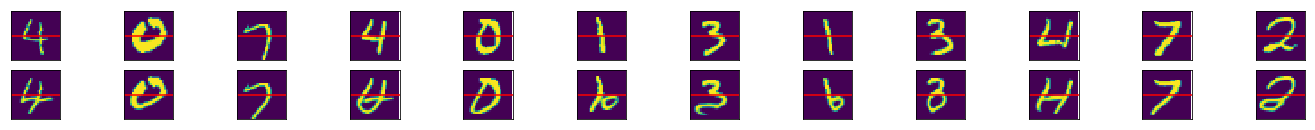

In [8]:
fig, ax = plt.subplots(2,12, figsize=(24,2))
for i in range(12):
    a1, a2 = ax[:, i]
    a1.set_xticks([])
    a2.set_xticks([])
    a1.imshow(x.asnumpy()[i,0,:,:])
    a1.plot([0,28], [14,14], 'r')
    a2.imshow(reconst.asnumpy()[i,0,:,:])
    a2.plot([0,28], [14,14], 'r')
    a1.set_xticks([])
    a2.set_xticks([])
    a1.set_xlim([0,28])
    a2.set_xlim([0,28])
    a1.set_yticks([])
    a2.set_yticks([])